<a href="https://colab.research.google.com/github/wxyyoyo/2D-Motion-Retargeting/blob/master/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown ### **Installing pip packages**
#@markdown - Diffusion Model: [PyTorch](https://pytorch.org) & [HuggingFace diffusers](https://huggingface.co/docs/diffusers/index)
#@markdown - Dataset Loading: [Zarr](https://zarr.readthedocs.io/en/stable/) & numcodecs
#@markdown - Push-T Env: gym, pygame, pymunk & shapely
!python --version
!pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 \
scikit-image==0.19.3 scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.10.2 \
pygame==2.1.2 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 \
&> /dev/null # mute output

Python 3.10.12


In [2]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math
import torch
import torch.nn as nn
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
#@markdown ### **Environment**
#@markdown Defines a PyMunk-based Push-T environment `PushTEnv`.
#@markdown
#@markdown **Goal**: push the gray T-block into the green area.
#@markdown
#@markdown Adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/)


positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x

When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y

"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)


def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=96,
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"


        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * 96).astype(np.int32)
                marker_size = int(8/96*self.render_size)
                thickness = int(1/96*self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([100,100,np.pi/4])  # x, y, theta (in radians)
        #self.add_box((300,200), 50, 50)
        self.add_snowman((300, 200), 0)
        self.add_shape((400, 400), 0)

        # Add collision handeling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices2)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body

    def add_snowman(self,position, angle, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        inertia1 = pymunk.moment_for_circle(mass=1, inner_radius=0, outer_radius=20)
        inertia2 = pymunk.moment_for_circle(mass=5, inner_radius=0, outer_radius=30)
        body = pymunk.Body(mass=6, moment=inertia1 + inertia2)
        body.position = (400, 400)
        #body.apply_impulse_at_local_point((100, 0))

        c1 = pymunk.Circle(body, radius=20, offset=(0, 0))
        c1.elasticity = 0.999
        c1.filter = pymunk.ShapeFilter(mask=mask)

        c2 = pymunk.Circle(body, radius=30, offset=(0, 50))
        c2.elasticity = 0.999
        c2.color = (255, 0, 0, 0)
        c2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (c1.center_of_gravity + c2.center_of_gravity) / 2

        self.space.add(body, c1, c2)
        return body

    def add_shape(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        '''
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        '''

        vertices1 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)

        body = pymunk.Body(mass, inertia1)
        shape1 = pymunk.Poly(body, vertices1)
        #shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        #shape2.color = pygame.Color(color)
        #shape1.filter = pymunk.ShapeFilter(mask=mask)
        #shape2.filter = pymunk.ShapeFilter(mask=mask)
        #body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1)
        return body

In [232]:
# 0. create env object
env = PushTEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs, IGNORE_GIT_FOLDER_PATTERNS = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated, info = env.step(action)

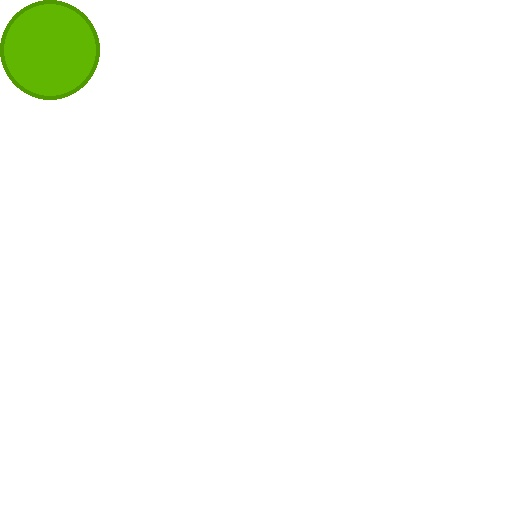

In [4]:
# test pygame draw options. pygame can draw without physics driven motions. In this module no pymunk is required.
# initiate a surface
WINDOW = pygame.Surface((512, 512))
WINDOW.fill((255, 255, 255))
#surface = pygame.Surface((512, 512))
# draw a simple circle
draw_options = DrawOptions(WINDOW)
draw_options.draw_circle(pos=Vec2d(50,50),angle=0,radius=50,outline_color=SpaceDebugColor(r=44.0, g=62.0, b=80.0, a=255.0),fill_color=SpaceDebugColor(r=0.0, g=152.0, b=80.0, a=255.0))
# or simply call pygame.draw.circle()
#pygame.draw.circle(WINDOW, pygame.Color('LightGreen'), (100, 100), 50)
# visualize the drawing
# pygame images cannot be visualized on google colab, so I copied it by cv2 into other image files.
img = np.transpose(np.array(pygame.surfarray.pixels3d(WINDOW)), axes=(1, 0, 2))
img = cv2.resize(img, (512, 512))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")


In [9]:
#import pdb

import gym
from gym import spaces
# test pygame used in a gym environment.
# create a gym.env
class TestEnv(gym.Env):
  # declaration and initiation
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    def __init__(self, render_mode=None, size=5):
      self.size = size  # The size of the square grid
      self.window_size = 512  # The size of the PyGame window
      # Observations are dictionaries with the agent's and the target's location.
      # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
      self.observation_space= spaces.Dict(
          {"agent": spaces.Box(0, size-1, shape=(2,), dtype = int), # agent has 2 dimensions to move horizental or verticle
           "target": spaces.Box(0, size-1, shape = (2,), dtype = int), # target has 2 dimensions to move
      })

      self.action_space = spaces.Discrete(4) # 4 actions: up, down, left, right
      """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
      """
      self._action_to_direction = {0: np.array([1,0]),
      1: np.array([0,1]),
      2: np.array([-1, 0]),
      3: np.array([0,-1]),
      }

      assert render_mode is None or render_mode in self.metadata["render_modes"]
      self.render_mode = render_mode
      self.window = None
      self.clock = None
      #Constructing Observations From Environment States
    def _get_obs(self):
        return {"agent_location": self._agent_location, "target_location": self._target_location}

    def _get_info(self):
        return np.linalg.norm(self._agent_location - self._target_location, ord=1)

      #reset
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # reset agent and target position
        self._agent_location = np.random.randint(0, self.size, size=2)
        self._target_location = self._agent_location


        while np.array_equal(self._target_location, self._agent_location):
          self._target_location = np.random.randint(0, self.size, size = 2)


        observation = self._get_obs()
        info = self._get_info()
        if self.render_mode == "human":
          self._render_frame()
        return observation, info

        # step
    def step(self, action):

          # map the direction of action
          direction = self._action_to_direction[action]
          self._agent_location = np.clip(self._agent_location + direction, 0, self.size-1)
          # An episode is done iff the agent has reached the target
          terminated = np.array_equal(self._agent_location, self._target_location)
          reward = 1 if terminated else 0
          observation = self._get_obs()
          info = self._get_info()
          if self.render_mode == "human":
            self._render_frame()
          return observation, reward, terminated, False, info

        # rendering
    def render(self):
          if self.render_mode == 'rgb_array':
            return self._render_frame()

    def _render_frame(self):
          if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
          if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

          canvas = pygame.Surface((self.window_size, self.window_size))
          canvas.fill((255, 255, 255))
          pix_square_size = self.window_size/self.size # the size of a single grid square in pixels

          # draw target
          pygame.draw.rect(canvas,(100,0,0), pygame.Rect((pix_square_size*self._target_location[0], pix_square_size*self._target_location[1]), (pix_square_size, pix_square_size)))


          # draw agent
          pygame.draw.circle(canvas,(0,0,255), (self._agent_location + 0.5) * pix_square_size , pix_square_size/3)

          # draw grid lines
          for x in range(self.size +1):
            pygame.draw.line(canvas,0, (0, pix_square_size * x), (self.window_size, pix_square_size * x), width = 3)
            pygame.draw.line(canvas,0, (pix_square_size * x, 0), (pix_square_size * x, self.window_size), width = 3)

          if self.render_mode == "human":
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
          else: # rgb_gray
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
    def close(self):
          if self.window is not None:
            pygame.display.quit()
            pygame.quit()











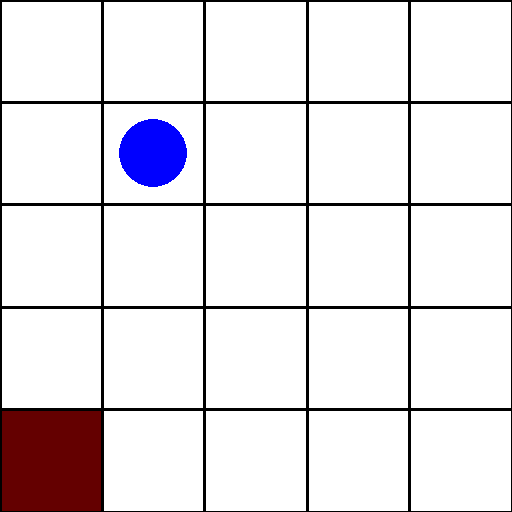

In [10]:
#test pygame env
myenv = TestEnv(render_mode="rgb_array")
obs, info = myenv.reset(seed = 800)


images = [myenv.render()]
for _ in range(200):
    action = myenv.action_space.sample()
    observation, reward, terminated, truncated, info = myenv.step(action)
    images.append(myenv.render())

    if terminated or truncated:
        observation, info = myenv.reset()
        images.append(myenv.render())
myenv.close()


%pip install numpngw
from numpngw import write_apng
write_apng("anim.png", images, delay=250)  # real-time rendering = 250 ms between frames
from IPython.display import Image

Image(filename="anim.png")


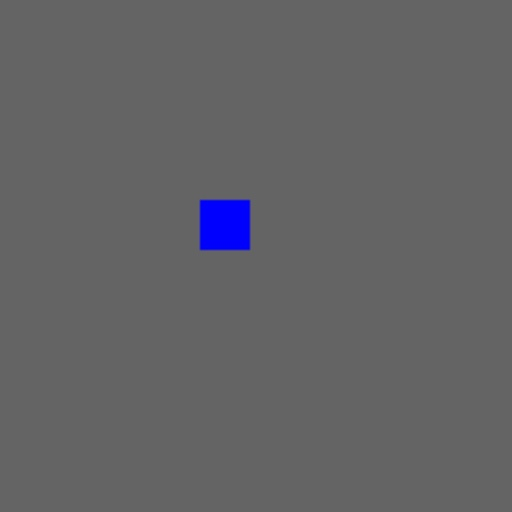

In [76]:
# test pygame.Rect
surface_test = pygame.Surface((256, 256))
surface_test.fill((100,100,100))
rect = pygame.Rect((100,100),(25,25)) # (left, top), (width,height)
pygame.draw.rect(surface_test, (255, 0, 0), rect)

img = np.transpose(np.array(pygame.surfarray.pixels3d(surface_test)), axes=(1, 0, 2))
img = cv2.resize(img, (512, 512))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")

In [233]:
images = [env.render(mode = 'rgb_array')]
for _ in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(env.render(mode='rgb_array'))

    if terminated or truncated:
        observation, info = env.reset()
        images.append(env.render())

env.close()

In [234]:
#%pip install numpngw
from numpngw import write_apng

write_apng("anim.png", images, delay=40)  # real-time rendering = 40 ms between frames

In [ ]:
from IPython.display import Image

Image(filename="anim.png")

In [5]:
# test tuple function
def testtuple(input:Tuple[float, float]) -> Tuple[float, float]:
  return input[0] + 0.1, input[1] + 1

#testtuple([0.1,0.2])
import pymunk
s = pymunk.Space()
b = pymunk.Body()
c = pymunk.Circle(b, 10)
c.mass = 3
s.add(b, c)
s.add(pymunk.Circle(s.static_body, 3))
s.step(0.01)
options = pymunk.SpaceDebugDrawOptions()
options.flags = pymunk.SpaceDebugDrawOptions.DRAW_SHAPES
s.debug_draw(options)

draw_circle (Vec2d(0.0, 0.0), 0.0, 10.0, SpaceDebugColor(r=44.0, g=62.0, b=80.0, a=255.0), SpaceDebugColor(r=52.0, g=152.0, b=219.0, a=255.0))
draw_circle (Vec2d(0.0, 0.0), 0.0, 3.0, SpaceDebugColor(r=44.0, g=62.0, b=80.0, a=255.0), SpaceDebugColor(r=149.0, g=165.0, b=166.0, a=255.0))
